# YSE Survey Simulation Metrics

I've generated SNANA simulations for a variety of Young Supernova Experiment survey designs and condensed the output into gzipped "pickle" files.  This notebook is a brief walkthrough of how to analyze the data and figure out some of the parameters of the survey.  All simulations are for **one year** of survey time.

Start by reading in the data.  The read_data function below adds some keys and re-organization to make it easy to parse the data later.  It also adds estimates of explosion time for each model that I've computed from "perfect" simulations.  Simulations use the transient models from the PLAsTiCC team.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# takes a minute to run
# this code adapted from the PLAsTiCC team
from read_pkl import read_data

In [2]:
pklfile = '../../pkl/yse_gr_gi_gz_10per_PLASTICC.pkl.gz'
X, y = read_data(pklfile)

### Histograms of peak mag and redshift

I'm going to walk through and make a few plots, which will hopefully clarify some of the structure of X.  I'll start with all SNe and then add in the group of SNe with at least 3 SNR > 5 detections.  For that, we have to loop through the X dictionary.

median redshift of 0.157
median redshift for >3 detections is 0.123
median SNR for >3 detections is 10.621


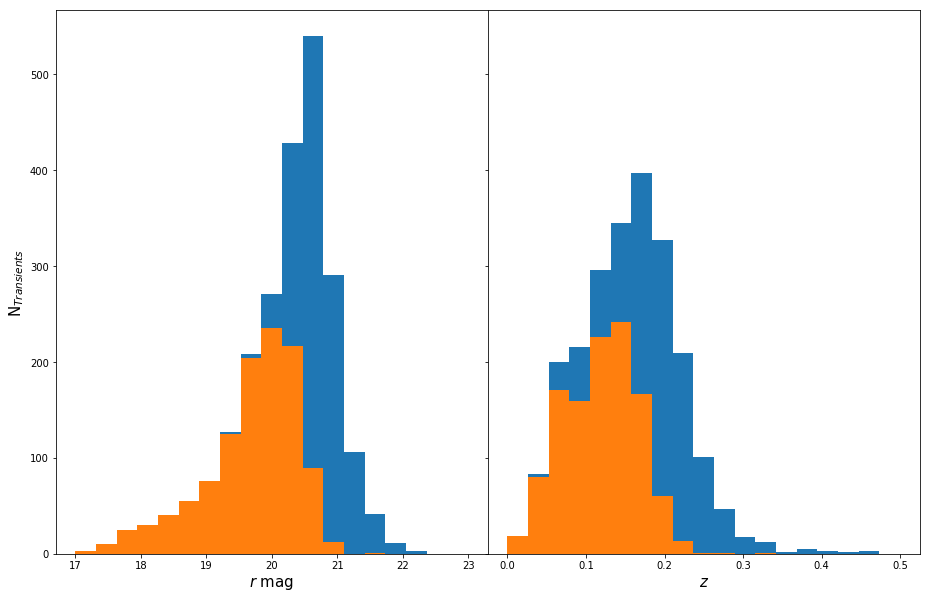

In [15]:
# peak mags and redshifts are easy
plt.subplots_adjust(
    left=0.1, bottom=None, right=0.9, top=None, wspace=0, hspace=0)
magbins = np.linspace(17,23,20)
zbins = np.linspace(0,0.5,20)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.hist(X.SIM_PEAKMAG_r,bins=magbins,label='all SNe')
ax2.hist(X.SIM_REDSHIFT_CMB,bins=zbins)
ax1.set_ylabel('N$_{Transients}$',fontsize=15)
ax2.yaxis.set_ticklabels([])
ax2.set_ylim(ax1.get_ylim())
ax1.set_xlabel('$r$ mag',fontsize=15)
ax2.set_xlabel('$z$',fontsize=15)

print('median redshift of %.3f'%np.median(X.SIM_REDSHIFT_CMB))


# but to get the peak mags/redshifts for things 
# with a certain SNR, we have to loop over the data
iSNR = []
SNR = []
for i,cid in enumerate(X.snid):
    sn = X.loc[cid]
    n_detect = 0
    for f in 'griz':
        n_detect += len(np.where(sn['fluxcal_%s'%f]/sn['fluxcalerr_%s'%f] \
                                 > 5)[0])
    if n_detect > 3: 
        iSNR += [i]
        SNR += [np.max(sn['fluxcal_g']/sn['fluxcalerr_g'])]
ax1.hist(X.SIM_PEAKMAG_r[X.index[iSNR]],bins=magbins,
         color='C1',label='3 SNR > 5 detections')
ax2.hist(X.SIM_REDSHIFT_CMB[X.index[iSNR]],bins=zbins,color='C1')
print('median redshift for >3 detections is %.3f'%(
    np.median(X.SIM_REDSHIFT_CMB[X.index[iSNR]])))
print('median SNR for >3 detections is %.3f'%np.median(SNR))
#import pdb; pdb.set_trace()

## Demographics and Composition of the Sample

I'm going to make a couple pie charts showing the number of SNe we're detecting and how many in a given survey design.

So far, we're not finding TDEs, so I need to look into this to see if the simulations are missing something or if TDEs are just too rare.

In [4]:
plt.rcParams['figure.figsize'] = (15,10)
types = ['SNIa-91bg','SNIax','CART','SNIIn','SNIb','SNIc','SNII','SNIa','ILOT']
def absolute_value(val):
    a  = np.round(val/100.*np.sum(sizes), 0)
    return '%i'%a

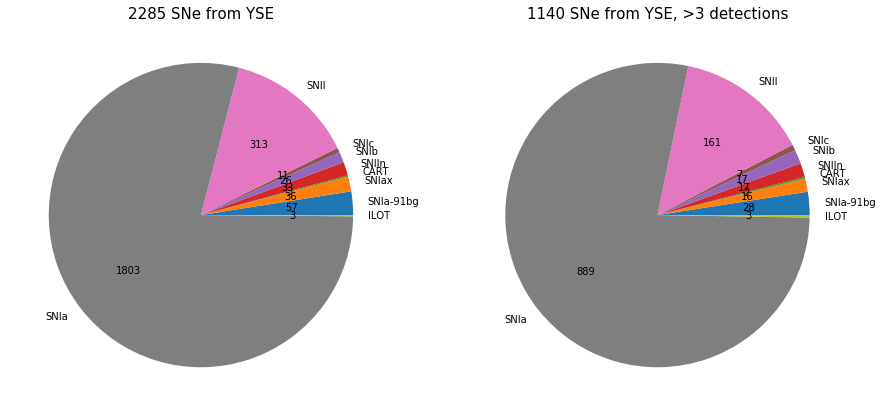

In [5]:
sizes = [len(X.snid[X.SIM_TYPE == t]) for t in types]
ax1,ax2 = plt.subplot(121),plt.subplot(122)
ax1.set_title('%i SNe from YSE'%np.sum(sizes),fontsize=15)
op = ax1.pie(sizes, labels=types,
    autopct=absolute_value, shadow=False)
sizes = [len(X.snid[X.index[iSNR]][X.SIM_TYPE[X.index[iSNR]] == t]) for t in types]
ax2.set_title('%i SNe from YSE, >3 detections'%np.sum(sizes),fontsize=15)
op = ax2.pie(sizes, labels=types,
    autopct=absolute_value, shadow=False)

### One-Day Survey
What SNe are we finding in the 1-day survey?

For simplicity's sake, the simulations treat the one-day survey as though it was happening *before* the full survey.  So to select the one-day survey, I'm choosing things where the avg cadence of PS1 observations after combining observations in all filters is < 1.5 days (this is a little weird but I think it works).

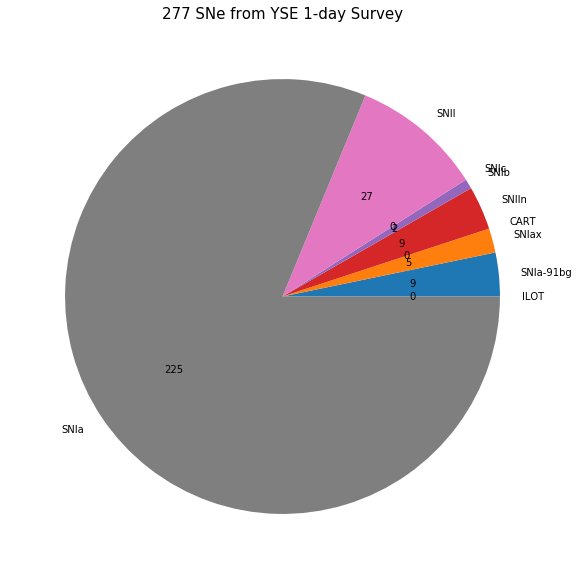

In [6]:
iOneDay = []
for i,cid in enumerate(X.snid):
    sn = X.loc[cid]
    mjd = np.concatenate((sn['mjd_g'],sn['mjd_r'],sn['mjd_i'],sn['mjd_z']))
    if np.median(mjd[1:10] -  mjd[:9]) > 2.0: continue
    iOneDay += [i]
if len(iOneDay):
    sizes = [len(X.snid[X.index[iOneDay]][X.SIM_TYPE[X.index[iOneDay]] == t]) for t in types]
    ax = plt.subplot(111)
    ax.set_title('%i SNe from YSE 1-day Survey'%np.sum(sizes),fontsize=15)
    op = ax.pie(sizes, labels=types,
        autopct=absolute_value, shadow=False)

### Young SNe
SNe within a couple days of first light.  The time of first light is set by looking at simulations of "perfect" SNe, the code is in `read_pkl.py`

In [16]:
# set number of preferred days from first light
max_days_from_firstlight = 2

iYoung = []
for i,cid in enumerate(X.snid):
    sn = X.loc[cid]
    firstdetect = np.min(np.concatenate((
        sn['photflag_g'],sn['photflag_r'],
        sn['photflag_i'],sn['photflag_z'])) - sn['SIM_PEAKMJD'])
    young = False
    # X and Y are ZTF g/R, so this is
    # giving SNe detected by *either* ZTF or PS1
    for filt in 'grizXY':
        # SNANA flags detections with bit-code 4096
        if len(np.where(sn['photflag_%s'%filt] == 4096)[0]):
            if np.min(sn['days_from_firstlight_%s' % filt][sn['photflag_%s'%filt] == 4096]) \
                <= max_days_from_firstlight: young = True
    if not young: continue
    iYoung += [i]

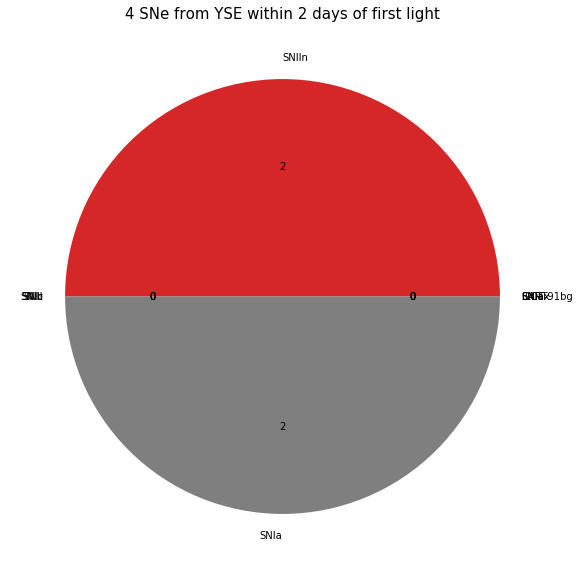

In [17]:
sizes = [len(X.snid[X.index[iYoung]][X.SIM_TYPE[X.index[iYoung]] == t]) for t in types]
ax = plt.subplot(111)
ax.set_title('%i SNe from YSE within %i days of first light'%(
    np.sum(sizes),max_days_from_firstlight),fontsize=15)
op = ax.pie(sizes, labels=types,
    autopct=absolute_value, shadow=False)

## A Few Light Curves

A couple general notes:

1) for dumb reasons, the ZTF g/R filters are labeled "X" and "Y", respectively
    
2) plotting can be much easier, most of the code below is formatting
    
3) For SN IIn, occasionally the red first light looks like it might not be right.  I'm not sure why this is - possibly substantial diversity in the MOSFIT models that are not fully recorded in the simulation outputs.  But for the most part things look ok (see LC plots)...

### Young SNe

In [9]:
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(6, 4)
gs1.update(left=0.2,wspace=0.0,right=0.95,hspace=0)

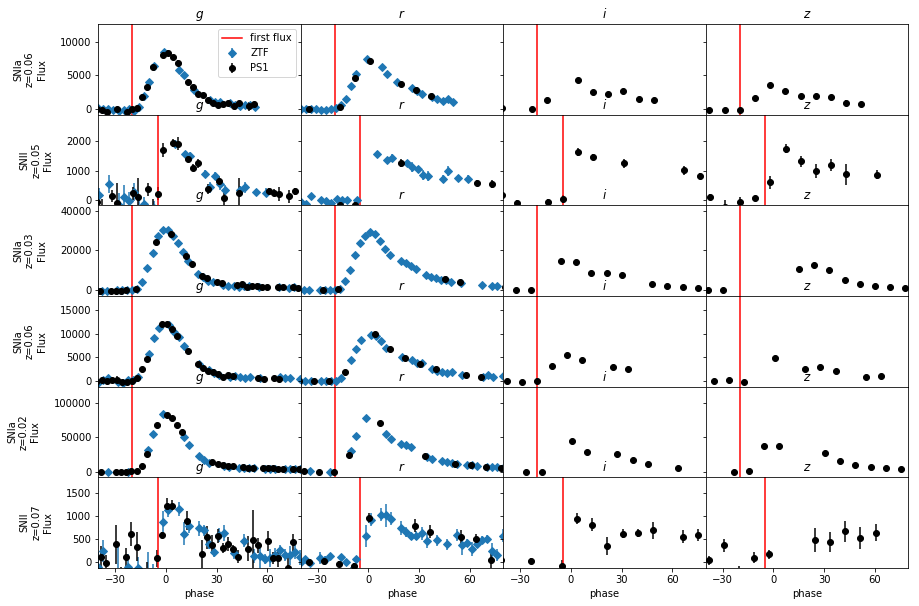

In [10]:
j = 0
for i in iYoung[:6]:
    sn = X.loc[X.index[i]]
    ax1 = plt.subplot(gs1[j % 24]); ax2 = plt.subplot(gs1[(j+1) % 24])
    ax3 = plt.subplot(gs1[(j+2) % 24]); ax4 = plt.subplot(gs1[(j+3) % 24])
    if j == 0:
        for f,ax in zip('griz',[ax1,ax2,ax3,ax4]):
            ax.set_title('$%s$'%f)
    for f,ax,label in zip('XY',[ax1,ax2],['ZTF','ZTF-r']):
        ax.errorbar(sn['mjd_%s'%f]-sn['SIM_PEAKMJD'],sn['fluxcal_%s'%f],
                    yerr=sn['fluxcalerr_%s'%f],fmt='D',label=label)
    for f,ax in zip('griz',[ax1,ax2,ax3,ax4]):
        ax.errorbar(sn['mjd_%s'%f]-sn['SIM_PEAKMJD'],sn['fluxcal_%s'%f],
                    yerr=sn['fluxcalerr_%s'%f],fmt='o',label='PS1',color='k')
        ax.set_title('$%s$'%f)
        ax.set_xlim([-40,80])
        ax.set_ylim([-1*0.1*np.max(np.concatenate((sn['fluxcal_g'][(sn['mjd_g']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_g']-sn['SIM_PEAKMJD'] < 80)],
                    sn['fluxcal_r'][(sn['mjd_r']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_r']-sn['SIM_PEAKMJD'] < 80)],
                    sn['fluxcal_i'][(sn['mjd_i']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_i']-sn['SIM_PEAKMJD'] < 80)],
                    sn['fluxcal_z'][(sn['mjd_z']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_z']-sn['SIM_PEAKMJD'] < 80)]))),
                     1.5*np.max(np.concatenate((sn['fluxcal_g'][(sn['mjd_g']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_g']-sn['SIM_PEAKMJD'] < 80)],
                    sn['fluxcal_r'][(sn['mjd_r']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_r']-sn['SIM_PEAKMJD'] < 80)],
                    sn['fluxcal_i'][(sn['mjd_i']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_i']-sn['SIM_PEAKMJD'] < 80)],
                    sn['fluxcal_z'][(sn['mjd_z']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_z']-sn['SIM_PEAKMJD'] < 80)])))])
        ax.xaxis.set_ticks([-30,0,30,60])
        ax.set_xlabel('phase')
        
        zeropt = -1*(sn['days_from_firstlight_g'][0] - (sn['mjd_g'][0] - sn['SIM_PEAKMJD']))
        ax.axvline(zeropt,color='r',label='first flux')
    if j == 0: ax1.legend()
    
    ax1.set_ylabel('%s\nz=%.2f\nFlux'%(
        sn['SIM_TYPE'],sn['z']),va='center',ha='center',labelpad=30)
    ax2.yaxis.set_ticklabels([]); ax3.yaxis.set_ticklabels([]); ax4.yaxis.set_ticklabels([])
    
    j += 4

### A Few Random Light Curves from the Full Sample

In [11]:
def plotLCs(idx):
    j = 0
    for i in idx:
        sn = X.loc[X.index[i]]
        ax1 = plt.subplot(gs1[j % 24]); ax2 = plt.subplot(gs1[(j+1) % 24])
        ax3 = plt.subplot(gs1[(j+2) % 24]); ax4 = plt.subplot(gs1[(j+3) % 24])
        if j == 0:
            for f,ax in zip('griz',[ax1,ax2,ax3,ax4]):
                ax.set_title('$%s$'%f)
        for f,ax,label in zip('XY',[ax1,ax2],['ZTF','ZTF-r']):
            ax.errorbar(sn['mjd_%s'%f]-sn['SIM_PEAKMJD'],sn['fluxcal_%s'%f],
                        yerr=sn['fluxcalerr_%s'%f],fmt='.',label=label)
        for f,ax in zip('griz',[ax1,ax2,ax3,ax4]):
            ax.errorbar(sn['mjd_%s'%f]-sn['SIM_PEAKMJD'],sn['fluxcal_%s'%f],
                        yerr=sn['fluxcalerr_%s'%f],fmt='o',label='PS1',color='k')
            ax.set_title('$%s$'%f)
            ax.set_xlim([-40,80])
            ax.set_ylim([-1*0.1*np.max(np.concatenate((sn['fluxcal_g'][(sn['mjd_g']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_g']-sn['SIM_PEAKMJD'] < 80)],
                        sn['fluxcal_r'][(sn['mjd_r']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_r']-sn['SIM_PEAKMJD'] < 80)],
                        sn['fluxcal_i'][(sn['mjd_i']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_i']-sn['SIM_PEAKMJD'] < 80)],
                        sn['fluxcal_z'][(sn['mjd_z']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_z']-sn['SIM_PEAKMJD'] < 80)]))),
                         1.5*np.max(np.concatenate((sn['fluxcal_g'][(sn['mjd_g']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_g']-sn['SIM_PEAKMJD'] < 80)],
                        sn['fluxcal_r'][(sn['mjd_r']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_r']-sn['SIM_PEAKMJD'] < 80)],
                        sn['fluxcal_i'][(sn['mjd_i']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_i']-sn['SIM_PEAKMJD'] < 80)],
                        sn['fluxcal_z'][(sn['mjd_z']-sn['SIM_PEAKMJD'] > -40) & (sn['mjd_z']-sn['SIM_PEAKMJD'] < 80)])))])
            ax.xaxis.set_ticks([-30,0,30,60])
            ax.set_xlabel('phase')

        if j == 0: ax1.legend()
    
        ax1.set_ylabel('%s\nz=%.2f\nFlux'%(
            sn['SIM_TYPE'],sn['z']),va='center',ha='center',labelpad=30)
        ax2.yaxis.set_ticklabels([]); ax3.yaxis.set_ticklabels([]); ax4.yaxis.set_ticklabels([])
    
        j += 4

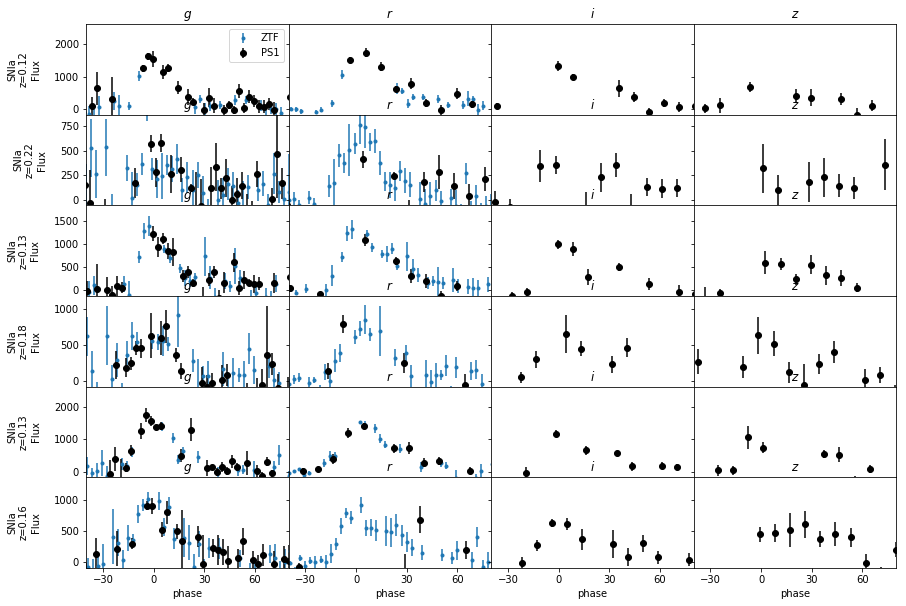

In [12]:
from random import sample
plotLCs(sample(range(len(X.snid)),6))

### A Few Random Light Curves from the One-Day Sample

There are some edge effects where we transition into the three-day survey at the end of the time range below because the method I'm using to simulate the one-day sample is clumsy and could be improved

In [13]:
# need to re-define the "one-day" sample to avoid edge effects in the LC plots
# this is because I (temporarily) defined the simulations such that the "start" 
# of the survey is the one-day cadence and the rest is nominal cadence
iOneDay = []
for i,cid in enumerate(X.snid):
    sn = X.loc[cid]
    mjd = np.concatenate((sn['mjd_g'],sn['mjd_r'],sn['mjd_i'],sn['mjd_z']))
    iMJD = np.where(mjd-sn['SIM_PEAKMJD'] > 10)[0]
    if np.median((mjd[iMJD][1:] -  mjd[iMJD][:-1])[:10]) > 2.0: continue
    if len(iMJD) < 5 or len(np.where(mjd-sn['SIM_PEAKMJD'] < -10)[0]) < 5: continue
    iOneDay += [i]

17


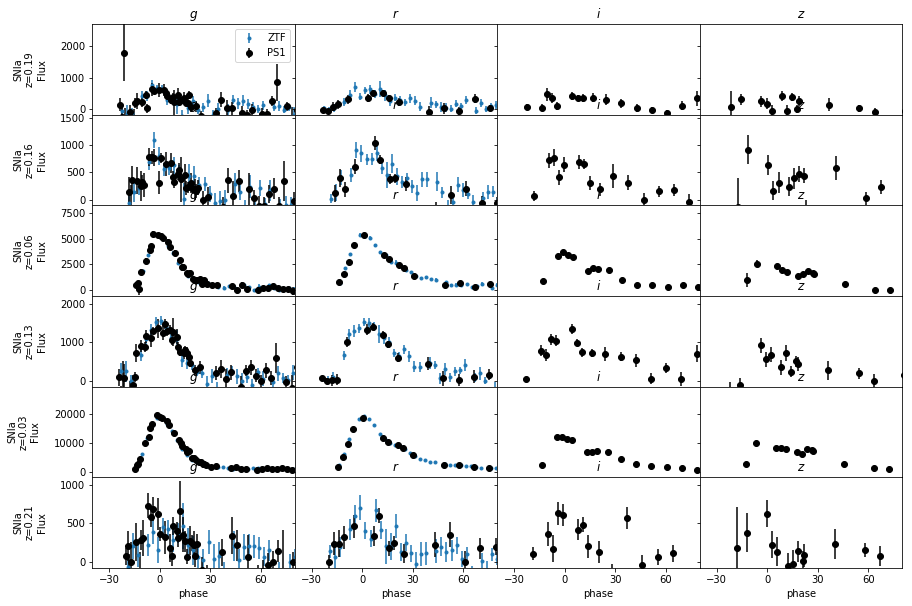

In [14]:
print(len(iOneDay))
if len(iOneDay): plotLCs(sample(iOneDay,6))